##### Downloading libraries 

In [39]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import math
import heapq

##### Print cities and connections

In [40]:
with open('json/2324_GIA04_CA5_Search_data_routes.json') as json_file:
    data = json.load(json_file)

cities = data['cities']
for city in cities:
    print(f"Name: {city['name']}")
    print(f"Address: {city['address']}")
    print(f"Country: {city['country']}")
    print(f"Latitude: {city['latitude']}")
    print(f"Longitude: {city['longitude']}")
    print()

connections = data['connections']
for connection in connections:
    print(f"From: {connection['from']}")
    print(f"To: {connection['to']}")
    print(f"Distance: {connection['distance']}")
    print(f"Duration: {connection['duration']}")
    print()

Name: Barcelona
Address: Barcelona, Spain
Country: ES
Latitude: 41.3850639
Longitude: 2.1734035

Name: Granollers
Address: Granollers, Barcelona, Spain
Country: ES
Latitude: 41.60619270000001
Longitude: 2.2870889

Name: L'Hospitalet de Llobregat
Address: L'Hospitalet de Llobregat, Barcelona, Spain
Country: ES
Latitude: 41.3661865
Longitude: 2.1164942

Name: MatarÃ³
Address: MatarÃ³, Barcelona, Spain
Country: ES
Latitude: 41.5381124
Longitude: 2.4447406

Name: Vic
Address: 08500 Vic, Barcelona, Spain
Country: ES
Latitude: 41.9304373
Longitude: 2.2544335

Name: PalamÃ³s
Address: PalamÃ³s, Girona, Spain
Country: ES
Latitude: 41.8505066
Longitude: 3.1298161

Name: Tremp
Address: 25620 Tremp, Lleida, Spain
Country: ES
Latitude: 42.1669147
Longitude: 0.8949296

Name: Sort
Address: Sort, Lleida, Spain
Country: ES
Latitude: 42.43785039999999
Longitude: 1.0873551

Name: Reus
Address: Reus, Tarragona, Spain
Country: ES
Latitude: 41.1498259
Longitude: 1.1055321

Name: Blanes
Address: 17300 Blanes

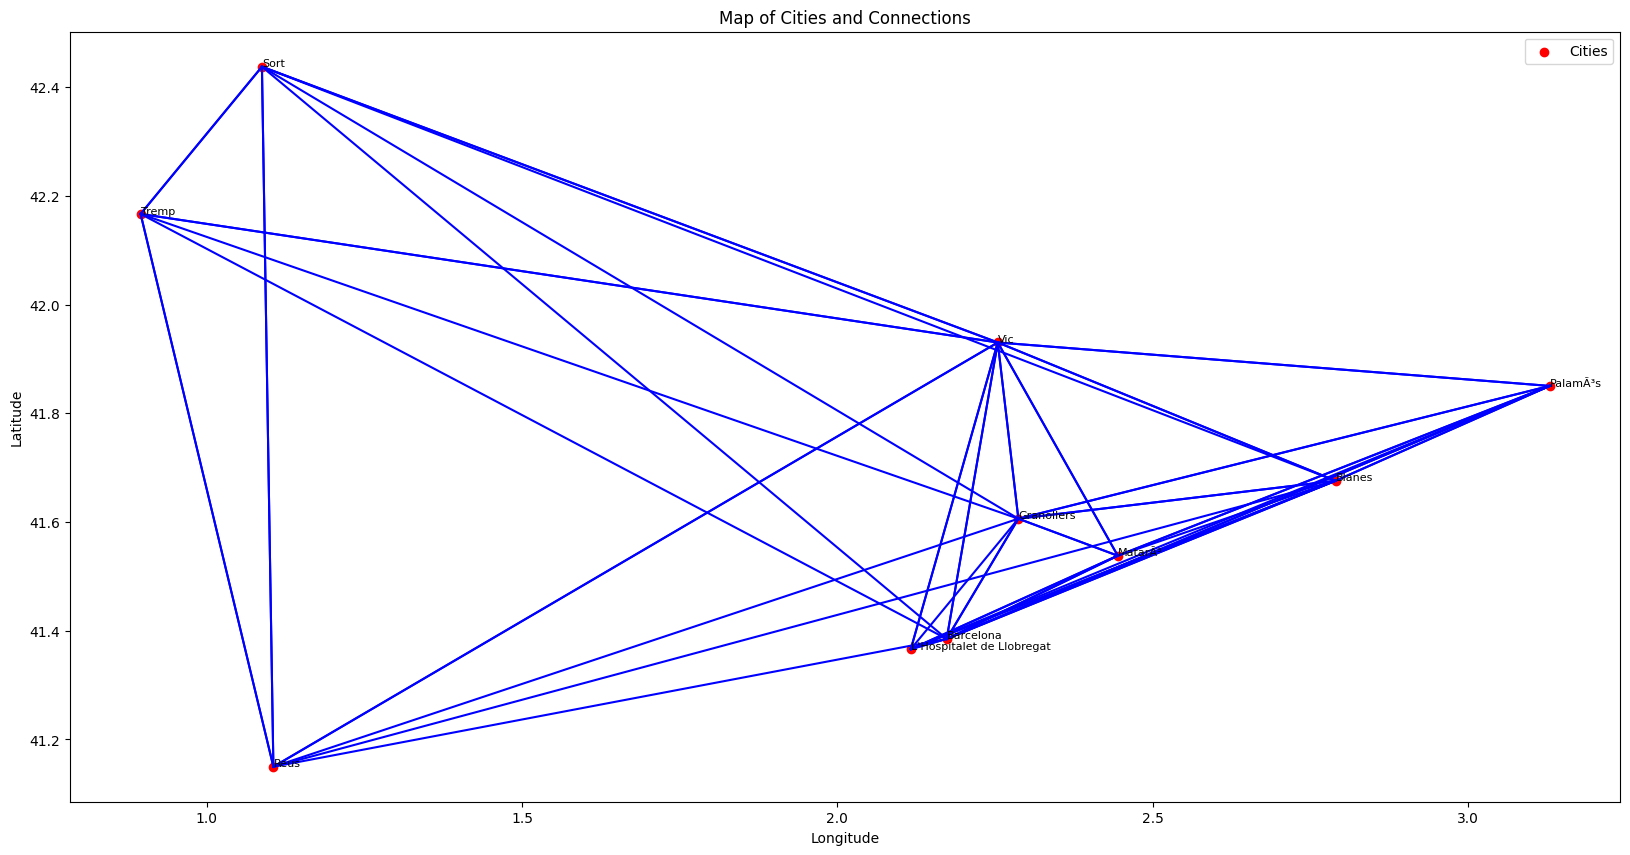

In [41]:
with open('json/2324_GIA04_CA5_Search_data_routes.json') as json_file:
    data = json.load(json_file)

dfcities = pd.DataFrame(data['cities'])
dfconnections = pd.DataFrame(data['connections'])

plt.figure(figsize=(20, 10))

plt.scatter(dfcities['longitude'], dfcities['latitude'], color='red', label='Cities')

for i, connection in dfconnections.iterrows():
    from_city = dfcities[dfcities['name'] == connection['from']]
    to_city = dfcities[dfcities['name'] == connection['to']]
    plt.plot([from_city['longitude'], to_city['longitude']], [from_city['latitude'], to_city['latitude']], 'b-')
    
for idx, row in dfcities.iterrows():
    plt.text(row['longitude'], row['latitude'], row['name'], fontsize=8)

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Map of Cities and Connections')
plt.legend()
plt.show()


### A*

Valid path found from Vic to Barcelona:
Total distance: 72554 km
Total duration: 63.88333333333333 minutes


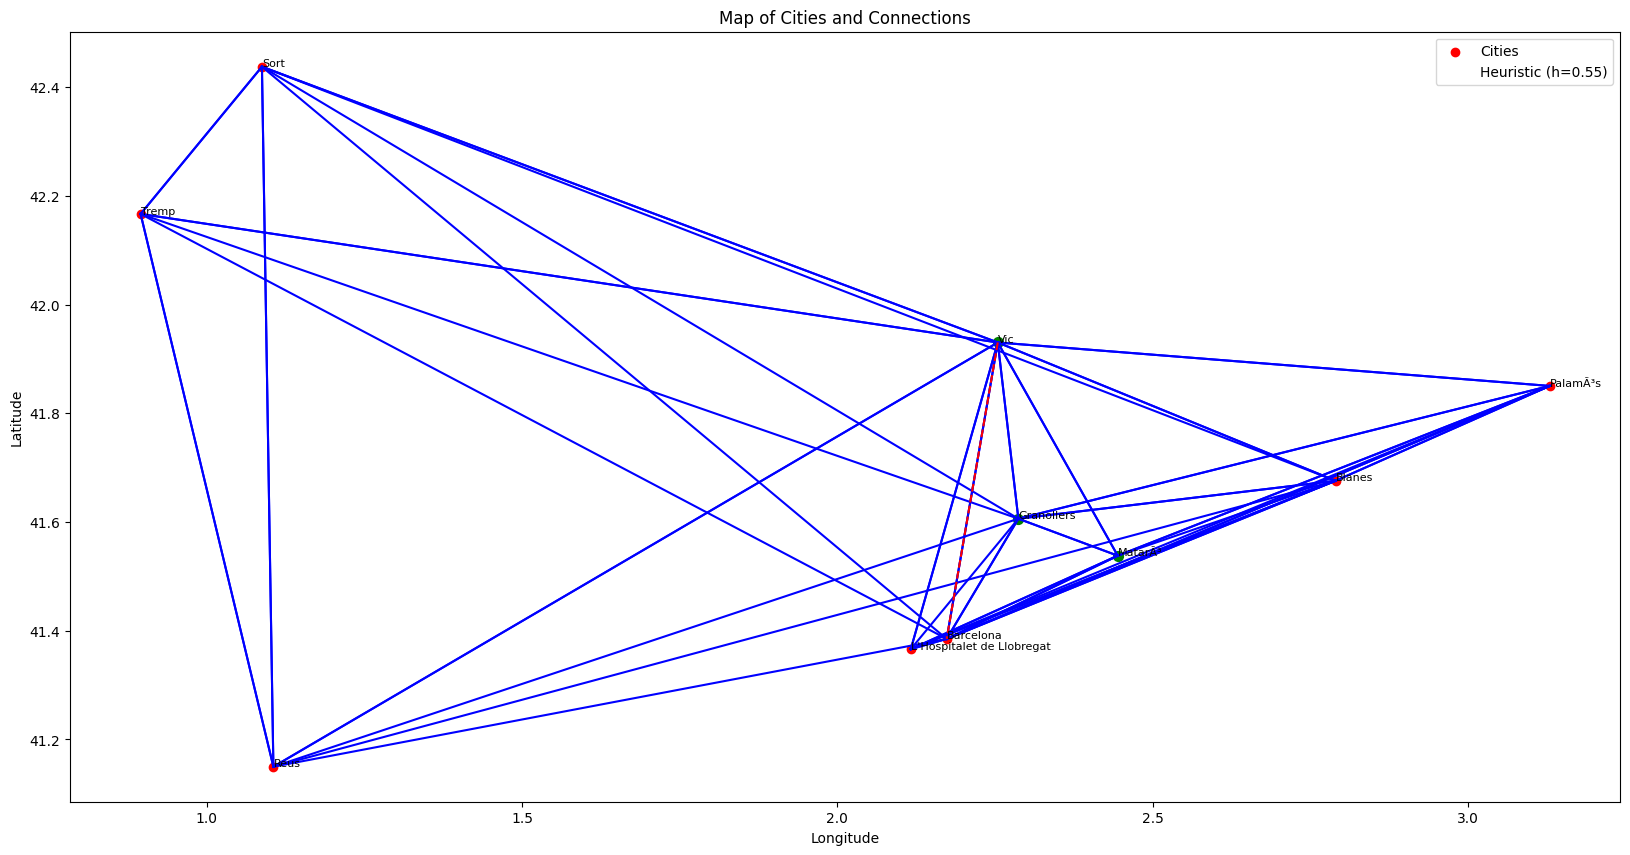

In [54]:
class CSPPathFinder:
    def __init__(self, json_file):
        self.json_file = json_file
        self.graph = None
        self.load_data()

    def load_data(self):
        with open(self.json_file) as file:
            data = json.load(file)
        cities = pd.DataFrame(data['cities'])
        connections = pd.DataFrame(data['connections'])
        
        self.graph = {}
        for idx, row in cities.iterrows():
            self.graph[row['name']] = []

        for idx, row in connections.iterrows():
            self.graph[row['from']].append((row['to'], row['distance'], row['duration']))

    def csp_path_finder(self, start, goal, max_distance, max_duration):
        L = []
        heapq.heappush(L, (0, 0, 0, start, [start]))  # Added heuristics
        explored = set()

        while L:
            f_score, distance, duration, current_node, path = heapq.heappop(L)

            if current_node == goal:
                return path, distance, duration, explored

            if current_node in explored:
                continue

            explored.add(current_node)

            for (neighbor, neighbor_distance, neighbor_duration) in self.graph[current_node]:
                if neighbor in explored:
                    continue
                
                new_distance = distance + neighbor_distance
                new_duration = duration + neighbor_duration / 60  # Convert seconds to minutes
                if new_distance <= max_distance and new_duration <= max_duration:
                    new_path = path + [neighbor]
                    # Here we use A* with the Euclidean distance as the heuristic
                    h_score = self.calculate_heuristic(neighbor, goal)
                    g_score = new_distance
                    heapq.heappush(L, (g_score + h_score, g_score, new_duration, neighbor, new_path))

        return None, None, None, explored

    def calculate_heuristic(self, current_node, goal):
        dfcities = pd.DataFrame(json.load(open(self.json_file))['cities'])
        current_city = dfcities[dfcities['name'] == current_node].iloc[0]
        goal_city = dfcities[dfcities['name'] == goal].iloc[0]
        dx = goal_city['longitude'] - current_city['longitude']
        dy = goal_city['latitude'] - current_city['latitude']
        return math.sqrt(dx ** 2 + dy ** 2)  # Euclidean distance

    def visualize_path_graph(self, path, explored):
        with open(self.json_file) as json_file:
            data = json.load(json_file)

        dfcities = pd.DataFrame(data['cities'])
        dfconnections = pd.DataFrame(data['connections'])

        plt.figure(figsize=(20, 10))

        plt.scatter(dfcities['longitude'], dfcities['latitude'], color='red', label='Cities') 

        for i, connection in dfconnections.iterrows():
            from_city = dfcities[dfcities['name'] == connection['from']]
            to_city = dfcities[dfcities['name'] == connection['to']]
            plt.plot([from_city['longitude'], to_city['longitude']], [from_city['latitude'], to_city['latitude']], 'b-')
            
        for idx, row in dfcities.iterrows():
            plt.text(row['longitude'], row['latitude'], row['name'], fontsize=8)

        if path:
            for i in range(len(path) - 1):
                from_city = dfcities[dfcities['name'] == path[i]]
                to_city = dfcities[dfcities['name'] == path[i+1]]
                plt.plot([from_city['longitude'].values[0], to_city['longitude'].values[0]], 
                        [from_city['latitude'].values[0], to_city['latitude'].values[0]], 'r--')

        if explored:
            for node in explored:
                city = dfcities[dfcities['name'] == node]
                plt.scatter(city['longitude'], city['latitude'], color='green', s=50)

        # Calculate heuristic between start and goal
        start_city = path[0] if path else None
        goal_city = path[-1] if path else None
        if start_city and goal_city:
            start_index = dfcities.index[dfcities['name'] == start_city][0]
            goal_index = dfcities.index[dfcities['name'] == goal_city][0]
            start_longitude, start_latitude = dfcities.loc[start_index, ['longitude', 'latitude']]
            goal_longitude, goal_latitude = dfcities.loc[goal_index, ['longitude', 'latitude']]
            h_score = self.calculate_heuristic(start_city, goal_city)
            plt.plot([start_longitude, goal_longitude], [start_latitude, goal_latitude], 
                    color='green', linestyle='--', linewidth=h_score*0.0001, label=f'Heuristic (h={h_score:.2f})')

        plt.xlabel('Longitude')
        plt.ylabel('Latitude')
        plt.title('Map of Cities and Connections')
        plt.legend()
        plt.show()

csp_path_finder = CSPPathFinder('json/2324_GIA04_CA5_Search_data_routes.json')

start_city = 'Vic'
goal_city = 'Barcelona'
max_distance = 150000 
max_duration = 90 

path, distance, duration, explored = csp_path_finder.csp_path_finder(start_city, goal_city, max_distance, max_duration)

if path:
    print(f"Valid path found from {start_city} to {goal_city}:")
    print(f"Total distance: {distance} km")
    print(f"Total duration: {duration} minutes")
    csp_path_finder.visualize_path_graph(path, explored)
else:
    print(f"No valid path found from {start_city} to {goal_city} respecting the restrictions.")


### CSP Constraint Satisfaction Problem

Valid path found from Sort to Tremp: ['Sort', 'Tremp']
Total distance: 52618 km
Total duration: 58.06666666666667 minutes


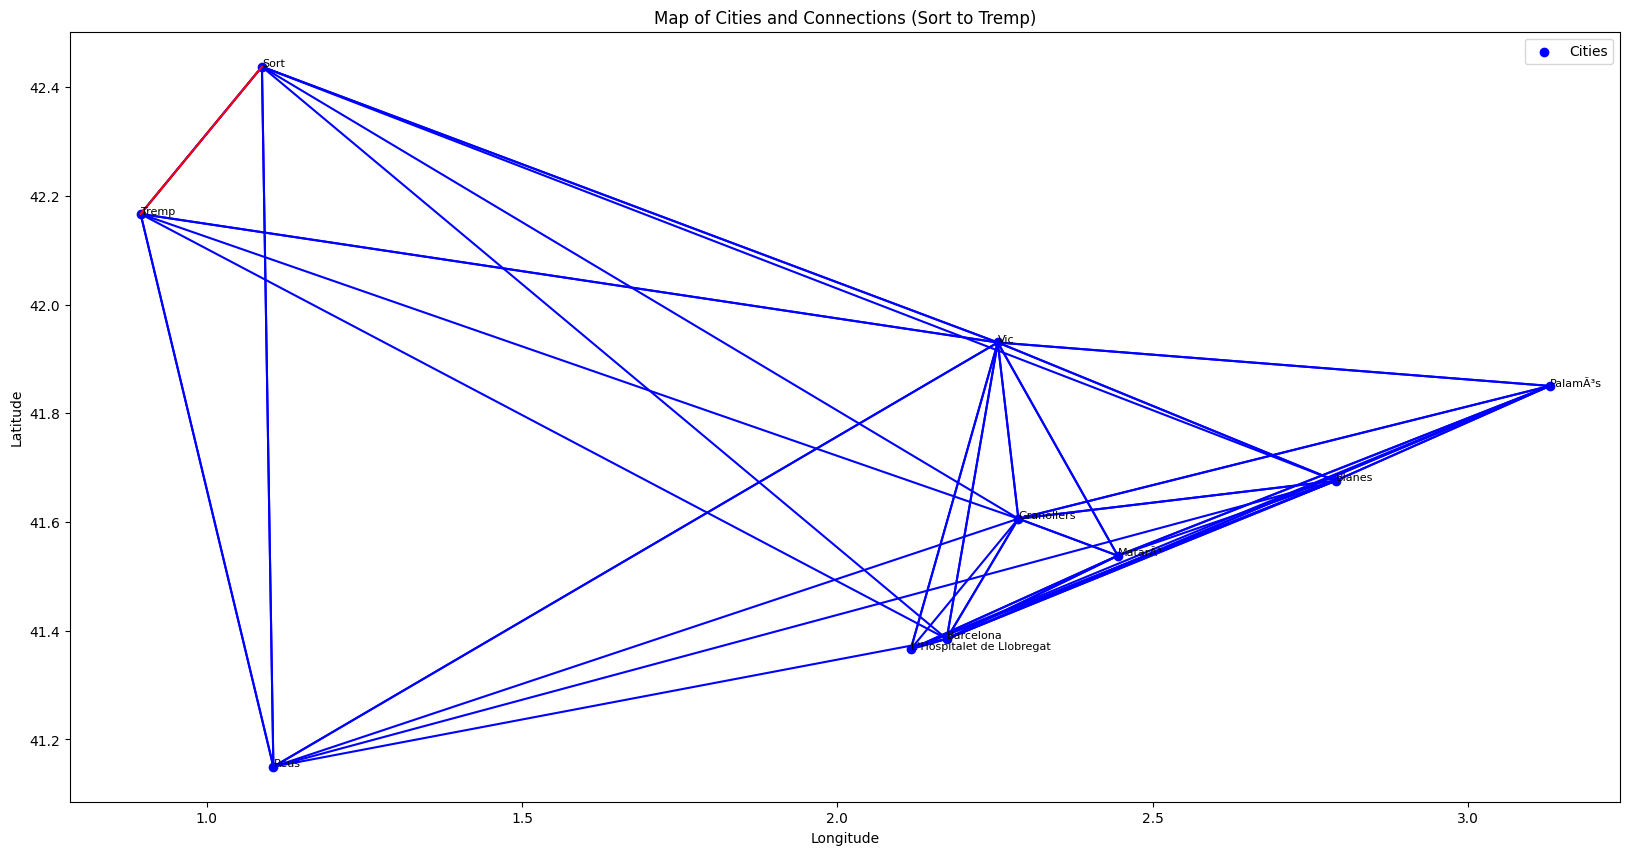

No valid path found from Blanes to Tremp respecting the restrictions.


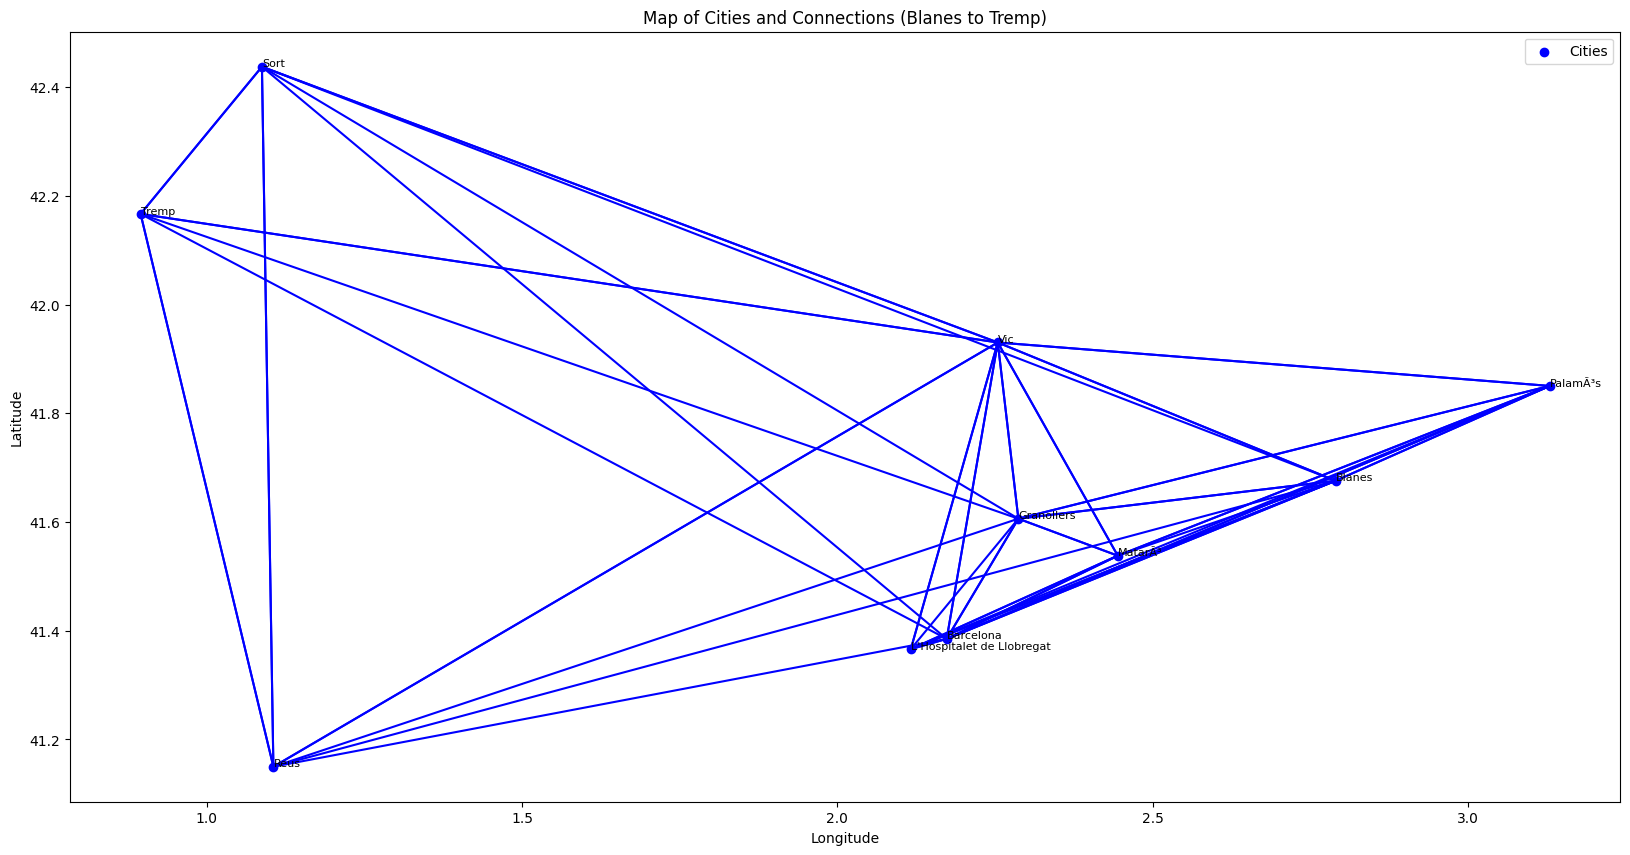

In [43]:
class CSPPathFinder:
    def __init__(self, json_file):
        self.json_file = json_file
        self.graph = None
        self.load_data()

    def load_data(self):
        with open(self.json_file) as file:
            data = json.load(file)
        cities = pd.DataFrame(data['cities'])
        connections = pd.DataFrame(data['connections'])
        
        self.graph = {}
        for idx, row in cities.iterrows():
            self.graph[row['name']] = []

        for idx, row in connections.iterrows():
            self.graph[row['from']].append((row['to'], row['distance'], row['duration']))

    def csp_path_finder(self, start, goal, max_distance, max_duration):
        L = []
        heapq.heappush(L, (0, 0, start, [start]))
        explored = set()

        while L:
            distance, duration, current_node, path = heapq.heappop(L)

            if current_node == goal:
                return path, distance, duration

            if current_node in explored:
                continue

            explored.add(current_node)

            for (neighbor, neighbor_distance, neighbor_duration) in self.graph[current_node]:
                if neighbor in explored:
                    continue
                
                if distance + neighbor_distance <= max_distance and (duration + neighbor_duration/60) <= max_duration:
                    new_distance = distance + neighbor_distance
                    new_duration = duration + neighbor_duration/60  # Convert seconds to minutes
                    new_path = path + [neighbor]
                    heapq.heappush(L, (new_distance, new_duration, neighbor, new_path))

        return None, None, None

    def visualize_path_graph(self, path, start_city, goal_city, max_distance, max_duration):
        with open('json/2324_GIA04_CA5_Search_data_routes.json') as json_file:
            data = json.load(json_file)

        dfcities = pd.DataFrame(data['cities'])
        dfconnections = pd.DataFrame(data['connections'])

        plt.figure(figsize=(20, 10))

        plt.scatter(dfcities['longitude'], dfcities['latitude'], color='blue', label='Cities')

        for i, connection in dfconnections.iterrows():
            from_city = dfcities[dfcities['name'] == connection['from']]
            to_city = dfcities[dfcities['name'] == connection['to']]
            plt.plot([from_city['longitude'], to_city['longitude']], [from_city['latitude'], to_city['latitude']], 'b-')

        for idx, row in dfcities.iterrows():
            plt.text(row['longitude'], row['latitude'], row['name'], fontsize=8)

        # Plot the path in red if it exists
        if path:
            for i in range(len(path) - 1):
                from_city = dfcities[dfcities['name'] == path[i]]
                to_city = dfcities[dfcities['name'] == path[i+1]]
                plt.plot([from_city['longitude'], to_city['longitude']], [from_city['latitude'], to_city['latitude']], 'r-')

        plt.xlabel('Longitude')
        plt.ylabel('Latitude')
        plt.title(f'Map of Cities and Connections ({start_city} to {goal_city})')
        plt.legend()
        plt.show()

csp_path_finder = CSPPathFinder('json/2324_GIA04_CA5_Search_data_routes.json')

start_city = 'Sort'
goal_city = 'Tremp'
max_distance = 150000 
max_duration = 90 

path, distance, duration = csp_path_finder.csp_path_finder(start_city, goal_city, max_distance, max_duration)
if path:
    print(f"Valid path found from {start_city} to {goal_city}: {path}")
    print(f"Total distance: {distance} km")
    print(f"Total duration: {duration} minutes")
else:
    print(f"No valid path found from {start_city} to {goal_city} respecting the restrictions.")

csp_path_finder.visualize_path_graph(path, start_city, goal_city, max_distance, max_duration)

start_city = 'Blanes'
max_duration = 90  

path, distance, duration = csp_path_finder.csp_path_finder(start_city, goal_city, max_distance, max_duration)
if path:
    print(f"Valid path found from {start_city} to {goal_city}: {path}")
    print(f"Total distance: {distance} km")
    print(f"Total duration: {duration} minutes")
else:
    print(f"No valid path found from {start_city} to {goal_city} respecting the restrictions.")

csp_path_finder.visualize_path_graph(path, start_city, goal_city, max_distance, max_duration)
